In [1]:
from osgeo import gdal,ogr,osr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import subprocess
import pickle
from sklearn.cluster import KMeans
import gc

In [2]:
# Adjust the path to match the actual location
input_dir = "D:\MasterThesis\subzone_e\e_ang20180722t212222rfl"
# input_dir = os.path.join(os.getcwd(), "e_ang20180722t212222rfl")
file = os.path.join(input_dir, "ang20180722t212222_rfl_v2r2_img")
# input_dir = os.path.join(os.getcwd(), "d_ang20190713t002123rfl")
# file = os.path.join(input_dir, "ang20190713t002123_rfl_v2v2_img")
# input_dir = os.path.join(os.getcwd(), "c_ang20180812t223939rfl")
# file = os.path.join(input_dir, "ang20180812t223939_rfl_v2r2_img")
# input_dir = os.path.join(os.getcwd(), "d_ang20180812t233938rfl")
# file = os.path.join(input_dir, "ang20180812t233938_rfl_v2r2_img")

hdr_file = f"{file}.hdr"

# Check if files exist
if os.path.exists(file):
    print(f"File exists: {file}")
else:
    print(f"File not found: {file}")

if os.path.exists(hdr_file):
    print(f"HDR File exists: {hdr_file}")
else:
    print(f"HDR File not found: {hdr_file}")

File exists: D:\MasterThesis\subzone_e\e_ang20180722t212222rfl\ang20180722t212222_rfl_v2r2_img
HDR File exists: D:\MasterThesis\subzone_e\e_ang20180722t212222rfl\ang20180722t212222_rfl_v2r2_img.hdr


In [3]:
# open the hyperspectral image file with GDAL
img_open = gdal.Open(file)

In [4]:
# read a few key properties of the image
nbands = img_open.RasterCount
ncols = img_open.RasterXSize
nrows = img_open.RasterYSize

print("\n".join(["Bands:\t"+str(nbands),"Cols (x-axis):\t"+str(ncols),"Rows (y-axis):\t"+str(nrows)]))

Bands:	425
Cols (x-axis):	689
Rows (y-axis):	17913


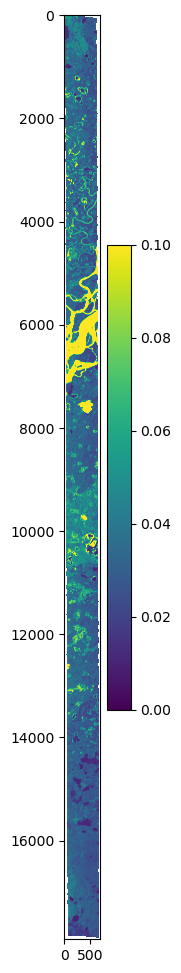

In [5]:
# read and display band 57 just to have a quick look at the image
img_red = img_open.GetRasterBand(57).ReadAsArray()
img_red = np.where(img_red == -9999, np.nan, img_red)
plt.rcParams["figure.figsize"] = [2,12]
plt.rcParams["figure.dpi"] = 100
plt.imshow(img_red,vmin=0, vmax=0.1)
plt.colorbar()
plt.show()

# Define the total number of bands
total_bands = nbands

# Define the ranges of bands to exclude
exclude_1 = range(1, 4)  # Excludes bands 1, 2, 3
exclude_2 = range(6, 9)  # Excludes bands 6, 7, 8
exclude_3 = range(11, 16)  # Excludes bands 6, 7, 8

# Combine all the excluded ranges into one list
excluded_bands = set(exclude_1).union(exclude_2).union(exclude_3)

# Get the list of all band indices
all_bands = list(range(1, total_bands + 1))

# Exclude the specified bands
remaining_bands = [str(band) for band in all_bands if band not in excluded_bands]

# Create the string in the desired format
krrper = " ".join([f"-b {band}" for band in remaining_bands])

# Print the result
print(krrper)


In [6]:
# Define NoData value
nodata_value = -9999

# Extract the required bands (band 57, 34, and 20)
band_57 = img_open.GetRasterBand(57).ReadAsArray()
band_34 = img_open.GetRasterBand(34).ReadAsArray()
band_20 = img_open.GetRasterBand(20).ReadAsArray()

# Replace NoData values with NaN (or any other appropriate value)
# set fill values (-9999.) to 0 for each array
band_57[band_57 == -9999.], band_34[band_34 == -9999.], band_20[band_20 == -9999.] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
band_57_8bit, band_34_8bit, band_20_8bit = scale8bit(band_57), scale8bit(band_34), scale8bit(band_20)

# set rescaled fill pixels back to 0 for each array
band_57_8bit[band_57 == 0], band_34_8bit[band_34 == 0], band_20_8bit[band_20 == 0] = 0, 0, 0

# c ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# make rgb stack
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = band_57_8bit, band_34_8bit, band_20_8bit


# Define a function to save the RGB image as a GeoTIFF
def save_rgb_as_tif(output_path, rgb_image, gdal_dataset):
    driver = gdal.GetDriverByName("GTiff")
    out_raster = driver.Create(
        output_path,
        gdal_dataset.RasterXSize,
        gdal_dataset.RasterYSize,
        3,  # RGB image has 3 bands
        gdal.GDT_Byte  # 8-bit unsigned integer for RGB
    )
    out_raster.SetGeoTransform(gdal_dataset.GetGeoTransform())
    out_raster.SetProjection(gdal_dataset.GetProjection())
    
    # Write the RGB bands to the GeoTIFF
    for i in range(3):  # Loop over the 3 channels (R, G, B)
        out_band = out_raster.GetRasterBand(i + 1)
        out_band.WriteArray(rgb_image[:,:,i])
        out_band.SetNoDataValue(0)
    
    out_raster.FlushCache()

# Define output file path
RGB_file = os.path.join(input_dir, "output_rgb_image.tif")

# Save the RGB image as a GeoTIFF
save_rgb_as_tif(RGB_file, rgb_stack, img_open)

print(f"RGB image saved as: {RGB_file}")


RGB image saved as: D:\MasterThesis\subzone_e\e_ang20180722t212222rfl\output_rgb_image.tif


# Calculate SAVI

In [7]:
def save_array(output_path, array, gdal_dataset, gdal_format):
    driver = gdal.GetDriverByName(gdal_format)
    out_raster = driver.Create(
        output_path,
        gdal_dataset.RasterXSize,
        gdal_dataset.RasterYSize,
        1,  # Single band
        gdal.GDT_Float32
    )
    out_raster.SetGeoTransform(gdal_dataset.GetGeoTransform())
    out_raster.SetProjection(gdal_dataset.GetProjection())
    out_band = out_raster.GetRasterBand(1)
    out_band.WriteArray(array)
    out_band.SetNoDataValue(np.nan)
    out_raster.FlushCache()

In [8]:
# Define band ranges for NIR, Green, and Red
nir_bands = range(86, 106)  # Bands 86 to 105 (1-based indexing in GDAL)
green_bands = range(26, 46)  # Bands 26 to 45
red_bands = range(56, 66)    # Bands 56 to 65

# Function to calculate the mean for a range of bands
def calculate_band_average(img, band_range):
    band_arrays = []
    for band_index in band_range:
        band_data = img.GetRasterBand(band_index).ReadAsArray()  # Read band
        band_data = np.where(band_data == -9999, np.nan, band_data)  # Replace invalid values with NaN
        band_arrays.append(band_data)
    # Stack bands and calculate the mean along the 0th axis
    return np.nanmean(np.stack(band_arrays, axis=0), axis=0)

# Calculate averages for each range
nir_average = calculate_band_average(img_open, nir_bands)
green_average = calculate_band_average(img_open, green_bands)
red_average = calculate_band_average(img_open, red_bands)


C:\Users\Patrick\AppData\Local\Temp\ipykernel_10432\3334558654.py:14: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(band_arrays, axis=0), axis=0)


In [9]:
# Define SAVI parameters
SAVI_L = 0.5  # Adjust this based on your requirements
SAVI_threshold = 0.2  # Example threshold for vegetation identification

# Calculate the SAVI
SAVI = ((nir_average - red_average) * (1 + SAVI_L)) / (nir_average + red_average + SAVI_L)

# Create a SAVI mask
savi_mask = np.where(SAVI > SAVI_threshold, 1, np.nan)

# Set value 0 to NaN to exclude unwanted pixels
#savi_mask = np.where(savi_mask == 0, np.nan, 1)

# Save SAVI and savi_mask

# ENVI format
SAVI_file_envi = os.path.join(input_dir, "SAVI")
SAVI_mask_file_envi = os.path.join(input_dir, "SAVI_mask")
save_array(SAVI_file_envi, SAVI, img_open,"ENVI")
save_array(SAVI_mask_file_envi, savi_mask, img_open,"ENVI")

#Geotiff format
SAVI_file = os.path.join(input_dir, "SAVI.tif")
SAVI_mask_file = os.path.join(input_dir, "SAVI_mask.tif")
save_array(SAVI_file, SAVI, img_open,"GTiff")
save_array(SAVI_mask_file, savi_mask, img_open,"GTiff")

SAVI mask saved as: /Volumes/T9/new_pca_test/e_ang20180722t212222rfl/data/hs_raw_image/SAVI_mask.tif


# Calculate NDWI

In [10]:
# Formula: NDWI = (Green – NIR)/(Green + NIR)

# Define NDWI parameters
# The NDWI values correspond to the following ranges:
# 0,2 – 1 – Water surface,
# 0.0 – 0,2 – Flooding, humidity,
# -0,3 – 0.0 – Moderate drought, non-aqueous surfaces,
# -1 – -0.3 – Drought, non-aqueous surfaces

NDWI_threshold = 0.2

# Calculate the SAVI
NDWI = (green_average - nir_average)/(green_average + nir_average)

# Create a SAVI mask
ndwi_mask = np.where(NDWI > NDWI_threshold, 1, np.nan)

# Set value 0 to NaN to exclude unwanted pixels
ndwi_mask = np.where(ndwi_mask == 0, np.nan, ndwi_mask)

# Save NDWI and ndwi_mask

# ENVI format
NDWI_file_envi = os.path.join(input_dir, "NDWI")
NDWI_mask_file_envi = os.path.join(input_dir, "NDWI_mask")
save_array(NDWI_file_envi, NDWI, img_open,"ENVI")
save_array(NDWI_mask_file_envi, ndwi_mask, img_open,"ENVI")

#Geotiff format
NDWI_file = os.path.join(input_dir, "NDWI.tif")
NDWI_mask_file = os.path.join(input_dir, "NDWI_mask.tif")
save_array(NDWI_file, NDWI, img_open,"GTiff")
save_array(NDWI_mask_file, ndwi_mask, img_open,"GTiff")



NDWI mask saved as: /Volumes/T9/new_pca_test/e_ang20180722t212222rfl/data/hs_raw_image/NDWI_mask.tif


: 

# Perform PCA

In [ ]:
# Load the SAVI mask
savi_mask_ds = gdal.Open(SAVI_mask_file)
savi_mask = savi_mask_ds.GetRasterBand(1).ReadAsArray()
savi_mask = np.where(savi_mask == 1, 1, np.nan)  # Keep only 1s, set others to NaN

# Prepare hyperspectral image data
bands = img_open.RasterCount  # Number of bands in the image
rows, cols = savi_mask.shape

# Initialize an empty list to store valid pixel data
valid_pixels = []

# Define the bands to include based on bblist
bblist = np.ones((425,))
bblist[0:14] = 0
bblist[189:225] = 0
bblist[281:336] = 0
bblist[405:] = 0

# Convert bblist to boolean mask for included bands
included_bands = np.where(bblist == 1)[0] + 1  # GDAL bands are 1-based
num_included_bands = len(included_bands)

# Loop through only the included bands
valid_pixels = []
for band_index in included_bands:
    band_data = img_open.GetRasterBand(int(band_index)).ReadAsArray()
    band_data = np.where(band_data == -9999, np.nan, band_data)  # Replace no-data values with NaN
    # Apply mask
    masked_data = band_data * savi_mask  # Retain only pixels where mask == 1
    valid_pixels.append(masked_data)

# Stack all bands into a single 3D array (bands, rows, cols)
image_stack = np.stack(valid_pixels, axis=0)

# Flatten the image stack (bands, rows*cols) and remove NaN
flattened_pixels = image_stack.reshape(num_included_bands, -1).T  # Shape: (pixels, included_bands)
filtered_pixels = flattened_pixels[~np.isnan(flattened_pixels).any(axis=1)]  # Exclude NaN

# Standardize the data (scaling)
scaler = StandardScaler()
filtered_pixels_scaled = scaler.fit_transform(filtered_pixels)

# Perform PCA
#n_components = 30  # Maximum number of PCs to retain
#pca = PCA(n_components=n_components)

variance_to_retaine = 0.999
pca = PCA(n_components=variance_to_retaine)

pca_result = pca.fit_transform(filtered_pixels_scaled)  # Shape: (valid_pixels, n_components)

In [27]:
# The number of components remaining
num_components = pca.n_components_
num_selected_pcs = num_components
print(f'Number of components to retain {pca.n_components*100}% variance: {num_components}')

Number of components to retain 99.9% variance: 17


In [17]:
# File path
pca_model_file = os.path.join(input_dir, "pca_model.pkl")
pca_result_file = os.path.join(input_dir, "pca_result.npz")

In [18]:
# Save PCA model using pickle
with open(pca_model_file, "wb") as f:
    pickle.dump(pca, f)

# Save PCA-transformed data using NumPy
np.savez(pca_result_file, pca_result=pca_result)

In [19]:
load_model = False

if(load_model):
    # Load PCA model
    with open(pca_model_file, "rb") as f:
        loaded_pca = pickle.load(f)

    # Load PCA-transformed data
    loaded_data = np.load(pca_result_file)
    loaded_pca_result = loaded_data["pca_result"]


In [20]:
# Access PCA results
#explained_variance = pca.explained_variance_ratio_
#cumulative_variance = np.cumsum(explained_variance)

#print("Explained Variance Ratio:", explained_variance)
#print("Cumulative Variance:", cumulative_variance)

Explained Variance Ratio: [8.24369986e-01 1.31139033e-01 3.23861147e-02 4.81371459e-03
 2.44870960e-03 1.49082971e-03 7.92803175e-04 4.86096155e-04
 2.79608955e-04 2.26141100e-04 1.40894800e-04 1.11219173e-04
 1.00856144e-04 7.67285166e-05 5.58663698e-05 4.95243383e-05
 4.56712290e-05]
Cumulative Variance: [0.82436999 0.95550902 0.98789513 0.99270885 0.99515756 0.99664839
 0.99744119 0.99792729 0.9982069  0.99843304 0.99857393 0.99868515
 0.99878601 0.99886274 0.9989186  0.99896813 0.9990138 ]


In [58]:
explained_variance_threshold = 0.999

# Select PCs that explain 99% variance
#num_selected_pcs = np.searchsorted(cumulative_variance, explained_variance_threshold) + 1  # Find index where cumulative variance >= 99%
#selected_pcs = pca_result[:, :num_selected_pcs]  # Retain only the selected PCs
#all_pcs = pca_result[:, :num_components]
all_pcs = pca_result[:, :]
#print(int(num_selected_pcs))

NameError: name 'n_components' is not defined

In [ ]:
# Create a vector of selected component numbers
selected_component_numbers = list(range(1, num_selected_pcs + 1))

print(f"PCs selected: {num_selected_pcs}")

# File path
pc_number_file = os.path.join(input_dir, "Selected_Components.txt")

# Open the file in write mode
with open(pc_number_file, "w") as file:
    # Write each number on a new line
    for i in range(1, num_selected_pcs + 1):
        file.write(f"{i}\n")

print(f"Optimal number of clusters saved to {pc_number_file}.")

In [19]:
# Reshape selected PCs back to spatial dimensions
#reshaped_selected_pcs = np.full((num_selected_pcs, rows, cols), np.nan)  # Initialize with NaN
reshaped_pcs = np.full((num_components, rows, cols), np.nan)  # Initialize with NaN
valid_indices = np.where(~np.isnan(flattened_pixels).any(axis=1))[0]

# reshape selected PCs
#for pc_index in range(num_selected_pcs):
#    reshaped_selected_pcs[pc_index][np.unravel_index(valid_indices, (rows, cols))] = selected_pcs[:, pc_index]

# reshape all PCs
for pc_index in range(num_components):
    reshaped_pcs[pc_index][np.unravel_index(valid_indices, (rows, cols))] = all_pcs[:, pc_index]

# File path
pc_number_file = os.path.join(input_dir, "Selected_Components.txt")

# Save the number to the file
with open(pc_number_file, 'w') as file:
    file.write(str(num_selected_pcs))

print(f"Optimal number of clusters saved to {pc_number_file}.")

In [20]:
# Save each PC as a separate band in a GeoTIFF
def save_multiband_tif(output_path, data, gdal_dataset):
    driver = gdal.GetDriverByName("GTiff")
    out_raster = driver.Create(output_path,
        gdal_dataset.RasterXSize,
        gdal_dataset.RasterYSize,
        data.shape[0],  # Number of bands
        gdal.GDT_Float32
    )
    out_raster.SetGeoTransform(gdal_dataset.GetGeoTransform())
    out_raster.SetProjection(gdal_dataset.GetProjection())
    
    for band_index in range(data.shape[0]):
        out_band = out_raster.GetRasterBand(band_index + 1)
        out_band.WriteArray(data[band_index])
        out_band.SetNoDataValue(np.nan)
    
    out_raster.FlushCache()

# Save the selected PCs as a GeoTIFF
#PCA_selection_file = os.path.join(input_dir, "PCA_selected.tif")
#save_multiband_tif(PCA_selection_file, reshaped_selected_pcs, img_open)

PCA_file = os.path.join(input_dir, "PCA.tif")
save_multiband_tif(PCA_file, reshaped_pcs, img_open)

In [ ]:
# Save the selected PCs as a GeoTIFF
Rectified_PCA_file = os.path.join(input_dir, "PCA_rectified")
#Rectified_PCA_selection_file = os.path.join(input_dir, "PCA_selection_rectified")

# Construct the GDAL command
gdal_command_rectify = [
    "gdalwarp",
    "-of", "ENVI",                   # Output format
    "-co", "INTERLEAVE=BIL",         # Create ENVI format with BIL interleaving
    "-dstnodata", "-9999",           # Set nodata value
    PCA_file,
    Rectified_PCA_file
]

# Execute the command in Python
try:
    subprocess.run(gdal_command_rectify, check=True)
    print(f"Rectified image saved to {Rectified_PCA_file}")
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}")


# Construct the GDAL command
#gdal_command_rectify_selection = [
#    "gdalwarp",
#    "-of", "ENVI",                   # Output format
#    "-co", "INTERLEAVE=BIL",         # Create ENVI format with BIL interleaving
#    "-dstnodata", "-9999",           # Set nodata value
#    PCA_selection_file,
#    Rectified_PCA_selection_file
#]

# Execute the command in Python
#try:
#    subprocess.run(gdal_command_rectify_selection, check=True)
#    print(f"Rectified image saved to {Rectified_PCA_selection_file}")
#except subprocess.CalledProcessError as e:
#    print(f"An error occurred: {e}")

In [ ]:
# Define the total number of bands
#total_bands = nbands

# Define the ranges of bands to exclude
#exclude_1 = range(1, 4)  # Excludes bands 1, 2, 3
#exclude_2 = range(6, 9)  # Excludes bands 6, 7, 8
#exclude_3 = range(11, 16)  # Excludes bands 6, 7, 8

# Combine all the excluded ranges into one list
#excluded_bands = set(exclude_1).union(exclude_2).union(exclude_3)

# Get the list of all band indices
#all_bands = list(range(1, num_selected_pcs + 1))

# Exclude the specified bands
# remaining_bands = [str(band) for band in all_bands if band not in excluded_bands]

# Create the string in the desired format
#rem_bands = " ".join([f"-b {band}" for band in all_bands])
# Split the string into a list
#band_selection_args = rem_bands.split()
#band_selection_args = str(band_selection_args)[1:-1]

# Print the result
#print(rem_bands)
#print(band_selection_args)

In [25]:
def gdal_transform(band_sel, input_file, output_file, output_format):
    # Construct the GDAL command
    gdal_command_subbands = [
        "gdal_translate",
        *band_sel,       #Unpack with asteriks
        "-of", 
        output_format,                   # Output format
        input_file,
        output_file
    ]

    print(gdal_command_subbands)

    # Execute the command in Python
    try:
        result = subprocess.run(gdal_command_subbands, check=True, text=True, capture_output=True)
        print(f"Command succeeded:\n{result.stdout}")
    except subprocess.CalledProcessError as e:
        print(f"Command failed:\n{e.stderr}")

In [ ]:
#PCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection")
#gdal_transform(band_selection_args,PCA_file,PCA_selection_file,"ENVI")

In [ ]:
#PCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection.tif")
#gdal_transform(band_selection_args,PCA_file,PCA_selection_file,"GTiff")

In [24]:
#plt.figure(figsize=(25,6))
#plt.plot(pca_result)
#plt.show()

# Reset workspace

In [29]:
%reset -f

In [ ]:
gc.collect()

# Perform WSS Elbow Method

In [ ]:
PCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection.tif")

In [38]:
# open the hyperspectral image file with GDAL
img_open_pca_selection = gdal.Open(PCA_file)

In [ ]:
# read a few key properties of the image
nbands_sel = img_open_pca_selection.RasterCount
ncols_sel = img_open_pca_selection.RasterXSize
nrows_sel = img_open_pca_selection.RasterYSize

print("\n".join(["Bands:\t"+str(nbands_sel),"Cols (x-axis):\t"+str(ncols_sel),"Rows (y-axis):\t"+str(nrows_sel)]))

In [40]:
# Initialize an empty array to hold the data
#pca_data_selection = np.empty((nbands_sel, nrows_sel, ncols_sel), dtype=np.float32)

In [41]:
# Read each band into the array
#for i in range(nbands_sel):
#    band = img_open_pca_selection.GetRasterBand(i + 1)
#    pca_data_selection[i] = band.ReadAsArray()

In [42]:
# Step 2: Flatten the PCA data
# Reshape into (pixels, bands)
pca_data_selection_2d = pca_selection_data.reshape(nbands_sel, -1).T

# Remove pixels with NaN values
valid_pixels = pca_data_selection_2d[~np.isnan(pca_data_selection_2d).any(axis=1)]

In [ ]:
# Step 3: Apply the elbow method
# Range of cluster counts to try
k_range = range(1, 30)
wcss = []  # Within-cluster sum of squares

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(valid_pixels)
    wcss.append(kmeans.inertia_)

In [ ]:
# Step 4: Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

In [ ]:
# Step 5: Determine optimal k (manual inspection or heuristic)
optimal_k = k_range[np.argmin(np.diff(wcss, 2)) + 1]  # Using the second derivative heuristic
print(f"Optimal number of clusters: {optimal_k}")

In [46]:
output_cluster_file = os.path.join(input_dir, "spectral_species.tif")

In [ ]:
# Step 2: Perform k-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
cluster_labels = kmeans.fit_predict(valid_pixels)

# Step 3: Reshape clustered data back into spatial dimensions
cluster_image = np.full((nrows_sel, ncols_sel), -9999, dtype=int    )  # Initialize with NaN
valid_indices = np.where(~np.isnan(pca_data_selection_2d).any(axis=1))[0]
cluster_image[np.unravel_index(valid_indices, (nrows_sel, ncols_sel))] = cluster_labels

# Step 4: Save the clustered image as GeoTIFF
driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create(
    output_cluster_file, ncols_sel, nrows_sel, 1, gdal.GDT_Int32
)

# Copy georeferencing information from PCA file
out_raster.SetGeoTransform(img_open_pca_selection.GetGeoTransform())
out_raster.SetProjection(img_open_pca_selection.GetProjection())

# Write cluster labels
out_band = out_raster.GetRasterBand(1)
out_band.WriteArray(cluster_image)
out_band.SetNoDataValue(-9999)  # Set NoData value for invalid pixels
out_band.FlushCache()

# Close datasets
out_raster = None
ds = None

print(f"K-means clustering result saved to {output_cluster_file}")